### IMPORT LIBRARY

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from joblib import dump
import os
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

import os, sys
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)

# import preprocessor
from model.preprocessing import IndonesianTextPreprocessor

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prata\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
datasets = pd.read_csv('../data/cleaned/clean_all_merged/clean_data_all.csv')

X = datasets['info']  # Text features
y = datasets['hoax']  # Binary labels (0=Fakta, 1=Hoax)

### SPLIT DATA FOR TRAINING AND TESTING

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    stratify=y, 
    random_state=42,
    shuffle=True
)

### TF-IDF VECTORIZER

In [6]:
custom_stopwords = {
    'yg', 'dg', 'rt', 'dgn', 'ny', 'dll', 'tsb', 'dr', 'pd',
    'scroll', 'resume', 'advertisement', 'iklan', 'sponsor', 'promo', 'baca',
    'klik', 'lanjut', 'selengkapnya', 'like', 'share', 'comment', 'subscribe',
    'follow', 'video', 'foto', 'gambar', 'infografis', 'caption', 'deskripsi',
    'sumber', 'reporter', 'editor', 'wartawan', 'penulis', 'kontributor', 'publisher',
    'simak', 'tonton', 'lihat', 'dengar', 'unduh', 'download',
    'republika', 'kompas', 'detik', 'tempo', 'cnn', 'bbc', 'rt', 'via',
    'twitter', 'facebook', 'instagram', 'youtube', 'tiktok',
    'halaman', 'kategori', 'narasi', 'verifikasi', 'referensi',
    'error', 'tagar', 'tulis', 'komen', 'read',
    'www', 'https', 'http', 'com', 'net', 'co', 'id'
}

stopwords_used = list(set(stopwords.words('indonesian')).union(custom_stopwords))

In [7]:
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1,3),
    stop_words=stopwords_used
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

c:\Users\prata\anaconda3\envs\AI_PROJECT\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


### SMOTEENN (SMOTE + ENN)
##### SMOTE = Synthetic Minority Over-sampling Technique || ENN = Edit Nearest Neighbours

In [8]:
smote_enn = SMOTEENN(
    smote=SMOTE(
        sampling_strategy=0.8,
        k_neighbors=3,
        random_state=42
    ),
    enn=EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='mode'
    ),
    random_state=42
)

# Resampling
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train_tfidf, y_train)

# Cek the result
print("Sebelum SMOTEENN:", Counter(y_train))
print("Setelah SMOTEENN:", Counter(y_train_bal))

Sebelum SMOTEENN: Counter({0: 17428, 1: 8820})
Setelah SMOTEENN: Counter({1: 13942, 0: 10036})


### TRAINING AND MODELLING

In [9]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model, tfidf, model_name=None):
    #take model name from model class if model_name=None
    if model_name is None:
        model_name = type(model).__name__

    # Training
    model.fit(X_train, y_train)
    
    # Prediction
    y_pred = model.predict(X_test)

     # Training Evaluation
    y_train_pred = model.predict(X_train)
    print(f"\n{'='*50}\n{model_name} TRAINING RESULTS\n{'='*50}")
    print(f"Accuracy  : {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Precision : {precision_score(y_train, y_train_pred):.4f}")
    print(f"Recall    : {recall_score(y_train, y_train_pred):.4f}")
    print(f"F1-score  : {f1_score(y_train, y_train_pred):.4f}")
    print("\nTraining Classification Report:")
    print(classification_report(y_train, y_train_pred, target_names=["Fakta", "Hoax"]))
    
    # Testing Evaluation
    print(f"\n{'='*50}\n{model_name} EVALUATION RESULTS\n{'='*50}")
    print(f"Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision : {precision_score(y_test, y_pred):.4f}")
    print(f"Recall    : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score  : {f1_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Fakta", "Hoax"]))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Fakta", "Hoax"], yticklabels=["Fakta", "Hoax"])
    plt.title(f"{model_name} - Confusion Matrix", fontweight='bold')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC AUC & Curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_tfidf)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC AUC Score : {roc_auc:.4f}")

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(5,3))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print(f"{model_name} not support predict_proba, ROC AUC can't be displayed.")

    inference_pipeline = Pipeline([
        ('preprocessor', IndonesianTextPreprocessor()),
        ('vectorizer', tfidf),
        ('model', model)
    ])

    # Overfitting check (basic)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"\n{'='*50}")
    print("📊 OVERFITTING CHECK:")
    print(f"Training Accuracy : {train_acc:.4f}")
    print(f"Testing Accuracy  : {test_acc:.4f}")
    print(f"Difference        : {train_acc - test_acc:.4f}")
    if train_acc - test_acc > 0.05:
        print("⚠️ Model may overfit (gap > 5%)")
    else:
        print("✅ Model might be balance (not overfit significantly)")
    print(f"{'='*50}")

    # Save pipeline into .joblib
    if not os.path.exists('final_model'):
        os.makedirs('final_model')
    filepath = f"final_model/{model_name.lower()}.joblib"
    dump(inference_pipeline, filepath)
    print(f"✅ Model saved to: {filepath}")

    return inference_pipeline

#### NAIVE BAYES


Naive Bayes:

MultinomialNB TRAINING RESULTS
Accuracy  : 0.9816
Precision : 0.9817
Recall    : 0.9867
F1-score  : 0.9842

Training Classification Report:
              precision    recall  f1-score   support

       Fakta       0.98      0.97      0.98     10036
        Hoax       0.98      0.99      0.98     13942

    accuracy                           0.98     23978
   macro avg       0.98      0.98      0.98     23978
weighted avg       0.98      0.98      0.98     23978


MultinomialNB EVALUATION RESULTS
Accuracy  : 0.9385
Precision : 0.8561
Recall    : 0.9820
F1-score  : 0.9147

Classification Report:
              precision    recall  f1-score   support

       Fakta       0.99      0.92      0.95      3076
        Hoax       0.86      0.98      0.91      1557

    accuracy                           0.94      4633
   macro avg       0.92      0.95      0.93      4633
weighted avg       0.95      0.94      0.94      4633



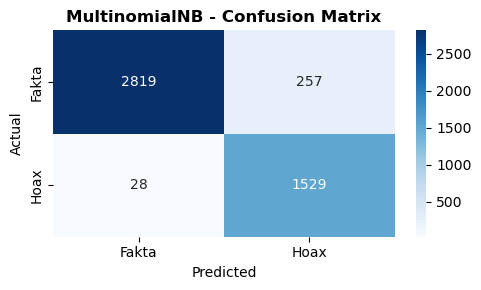

ROC AUC Score : 0.9932


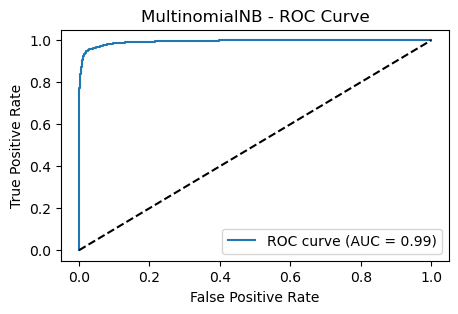


📊 OVERFITTING CHECK:
Training Accuracy : 0.9816
Testing Accuracy  : 0.9385
Difference        : 0.0431
✅ Model might be balance (not overfit significantly)
✅ Model saved to: final_model/multinomialnb.joblib


In [10]:
print("\nNaive Bayes:")
nb = train_and_evaluate(X_train_bal, y_train_bal, X_test_tfidf, y_test, MultinomialNB(), tfidf)

#### LOGISTIC REGRESSION


Logistic Regression:

LogisticRegression TRAINING RESULTS
Accuracy  : 0.9945
Precision : 0.9963
Recall    : 0.9941
F1-score  : 0.9952

Training Classification Report:
              precision    recall  f1-score   support

       Fakta       0.99      0.99      0.99     10036
        Hoax       1.00      0.99      1.00     13942

    accuracy                           0.99     23978
   macro avg       0.99      0.99      0.99     23978
weighted avg       0.99      0.99      0.99     23978


LogisticRegression EVALUATION RESULTS
Accuracy  : 0.9646
Precision : 0.9134
Recall    : 0.9884
F1-score  : 0.9494

Classification Report:
              precision    recall  f1-score   support

       Fakta       0.99      0.95      0.97      3076
        Hoax       0.91      0.99      0.95      1557

    accuracy                           0.96      4633
   macro avg       0.95      0.97      0.96      4633
weighted avg       0.97      0.96      0.96      4633



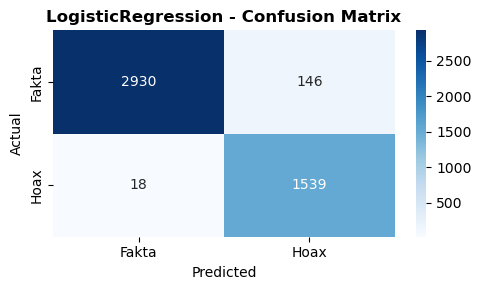

ROC AUC Score : 0.9967


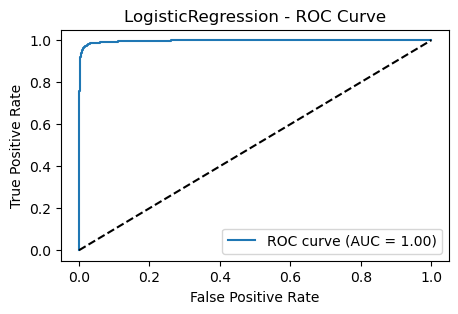


📊 OVERFITTING CHECK:
Training Accuracy : 0.9945
Testing Accuracy  : 0.9646
Difference        : 0.0299
✅ Model might be balance (not overfit significantly)
✅ Model saved to: final_model/logisticregression.joblib


In [11]:
print("\nLogistic Regression:")
lr = train_and_evaluate(X_train_bal, y_train_bal, X_test_tfidf, y_test, 
    LogisticRegression(
        max_iter=1000, 
        random_state=42
    ),
    tfidf
)

#### SUPPORT VECTOR MACHINE (SVM)


SVM:

SVC TRAINING RESULTS
Accuracy  : 0.9990
Precision : 0.9993
Recall    : 0.9991
F1-score  : 0.9992

Training Classification Report:
              precision    recall  f1-score   support

       Fakta       1.00      1.00      1.00     10036
        Hoax       1.00      1.00      1.00     13942

    accuracy                           1.00     23978
   macro avg       1.00      1.00      1.00     23978
weighted avg       1.00      1.00      1.00     23978


SVC EVALUATION RESULTS
Accuracy  : 0.9739
Precision : 0.9352
Recall    : 0.9910
F1-score  : 0.9623

Classification Report:
              precision    recall  f1-score   support

       Fakta       1.00      0.97      0.98      3076
        Hoax       0.94      0.99      0.96      1557

    accuracy                           0.97      4633
   macro avg       0.97      0.98      0.97      4633
weighted avg       0.98      0.97      0.97      4633



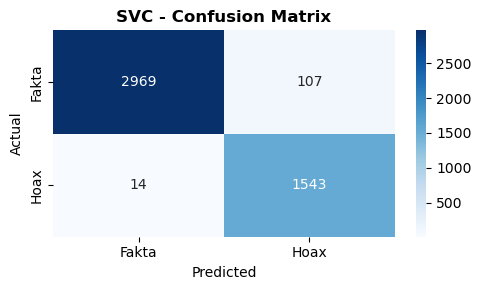

ROC AUC Score : 0.9980


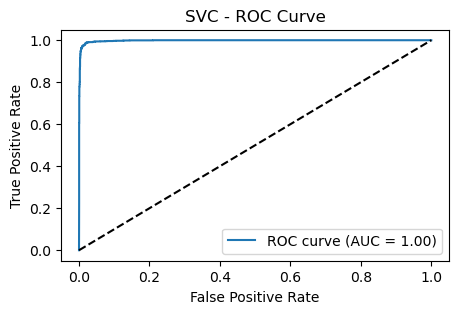


📊 OVERFITTING CHECK:
Training Accuracy : 0.9990
Testing Accuracy  : 0.9739
Difference        : 0.0252
✅ Model might be balance (not overfit significantly)
✅ Model saved to: final_model/svc.joblib


In [12]:
print("\nSVM:")
svm = train_and_evaluate(X_train_bal, y_train_bal, X_test_tfidf, y_test, 
    SVC(
    kernel='linear', 
    probability=True, 
    random_state=42
    ),
    tfidf
)

#### RANDOM FOREST


Random Forest:

RandomForestClassifier TRAINING RESULTS
Accuracy  : 0.9886
Precision : 0.9843
Recall    : 0.9963
F1-score  : 0.9902

Training Classification Report:
              precision    recall  f1-score   support

       Fakta       0.99      0.98      0.99     10036
        Hoax       0.98      1.00      0.99     13942

    accuracy                           0.99     23978
   macro avg       0.99      0.99      0.99     23978
weighted avg       0.99      0.99      0.99     23978


RandomForestClassifier EVALUATION RESULTS
Accuracy  : 0.9590
Precision : 0.8981
Recall    : 0.9904
F1-score  : 0.9420

Classification Report:
              precision    recall  f1-score   support

       Fakta       0.99      0.94      0.97      3076
        Hoax       0.90      0.99      0.94      1557

    accuracy                           0.96      4633
   macro avg       0.95      0.97      0.96      4633
weighted avg       0.96      0.96      0.96      4633



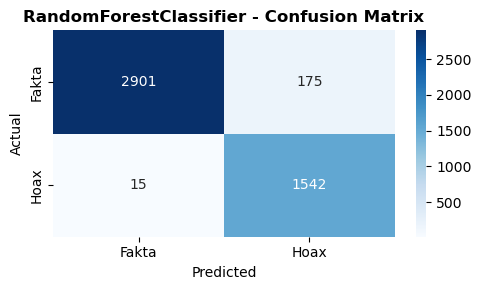

ROC AUC Score : 0.9979


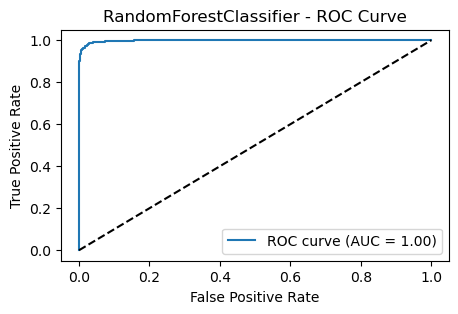


📊 OVERFITTING CHECK:
Training Accuracy : 0.9886
Testing Accuracy  : 0.9590
Difference        : 0.0296
✅ Model might be balance (not overfit significantly)
✅ Model saved to: final_model/randomforestclassifier.joblib


In [13]:
print("\nRandom Forest:")
rf = train_and_evaluate(X_train_bal, y_train_bal, X_test_tfidf, y_test, 
    RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        random_state=42
    ),
    tfidf
)

In [14]:
print("\nDataset Statistics:")
print(f"- Training set distribution:\n{y_train.value_counts()}")
print(f"- Test set distribution:\n{y_test.value_counts()}")


Dataset Statistics:
- Training set distribution:
hoax
0    17428
1     8820
Name: count, dtype: int64
- Test set distribution:
hoax
0    3076
1    1557
Name: count, dtype: int64


In [15]:
data = {
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest'],
    'Accuracy': [0.9385, 0.9646, 0.9739, 0.9590],
    'Precision': [0.8561, 0.9134, 0.9352, 0.8981],
    'Recall': [0.9820, 0.9884, 0.9910, 0.9904],
    'F1-Score': [0.9147, 0.9494, 0.9623, 0.9420]
}

# Buat DataFrame
df = pd.DataFrame(data)

# Tampilkan tabel
df

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.9385,0.8561,0.9820,0.9147
1,Logistic Regression,0.9646,0.9134,0.9884,0.9494
2,SVM,0.9739,0.9352,0.9910,0.9623
3,Random Forest,0.9590,0.8981,0.9904,0.9420


### SHOW INFLUENTIAL WORDS IN HOAX VS FACT NEWS INFO

In [16]:
def show_top_words(pipeline, top_n=15):
    # Ambil vectorizer dan model dari pipeline sesuai nama step di train_and_evaluate
    vectorizer = pipeline.named_steps['vectorizer']
    model = pipeline.named_steps['model']
    words = vectorizer.get_feature_names_out()

    # Tentukan cara ambil coef berdasarkan model
    if hasattr(model, "coef_"):
        # Untuk model linear, bisa jadi sparse matrix → convert ke array
        coef = model.coef_[0].toarray().flatten() if hasattr(model.coef_[0], 'toarray') else model.coef_[0]
    elif hasattr(model, "feature_log_prob_"):  # Naive Bayes
        # Selisih log probabilitas kelas 1 dan kelas 0
        coef = model.feature_log_prob_[1] - model.feature_log_prob_[0]
    elif hasattr(model, "feature_importances_"):  # Random Forest
        coef = model.feature_importances_
    else:
        raise ValueError("Model dalam pipeline tidak didukung untuk visualisasi top words.")

    # Ambil indeks top kata untuk kelas hoax dan fakta
    top_hoax = np.argsort(coef)[-top_n:]    # Nilai tertinggi → kata yg mendukung kelas Hoax
    top_fact = np.argsort(coef)[:top_n]     # Nilai terendah  → kata yg mendukung kelas Fakta

    # Plot bar chart
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.barh(range(top_n), coef[top_fact], color='green')
    plt.yticks(range(top_n), [words[i] for i in top_fact])
    plt.title(f'Top {top_n} Kata Fakta (0)')

    plt.subplot(1, 2, 2)
    plt.barh(range(top_n), coef[top_hoax], color='red')
    plt.yticks(range(top_n), [words[i] for i in top_hoax])
    plt.title(f'Top {top_n} Kata Hoax (1)')

    plt.tight_layout()
    plt.show()


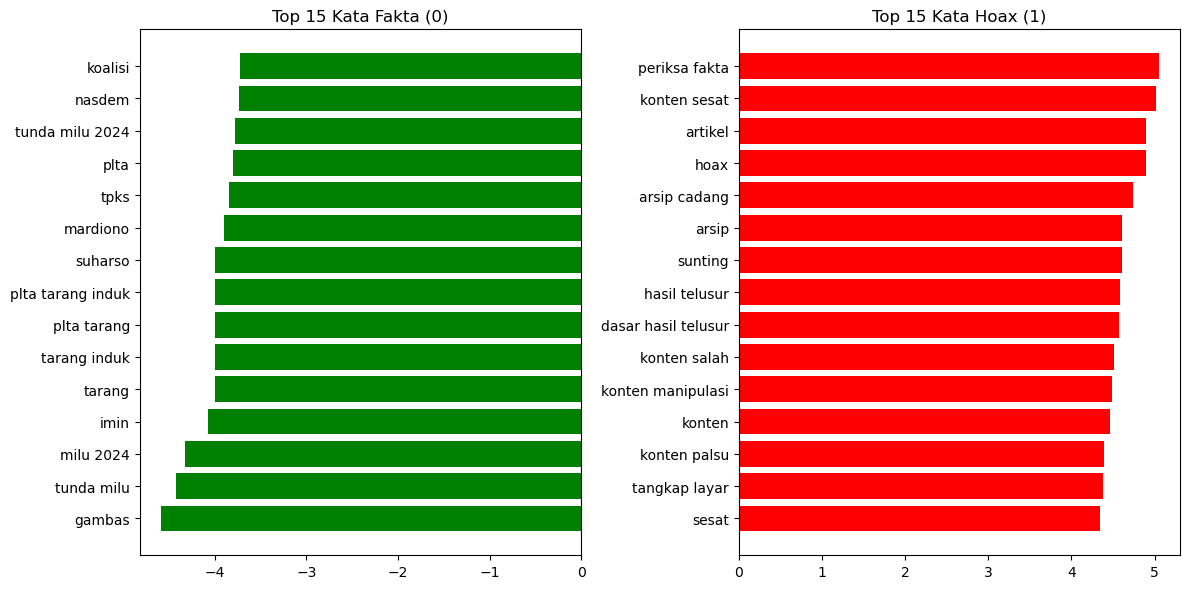

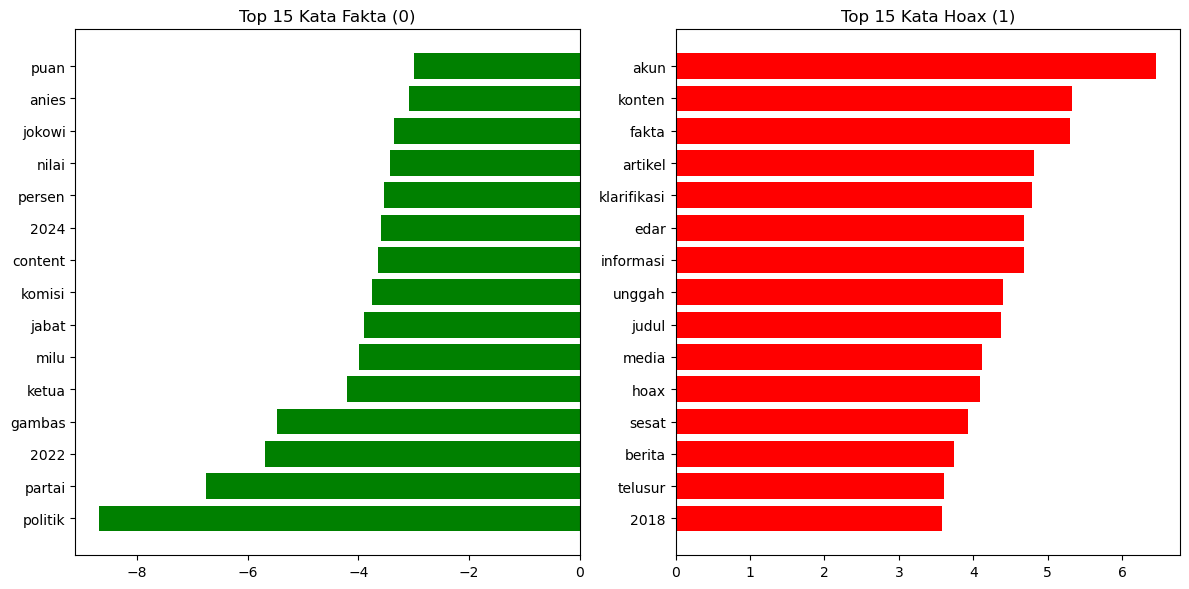

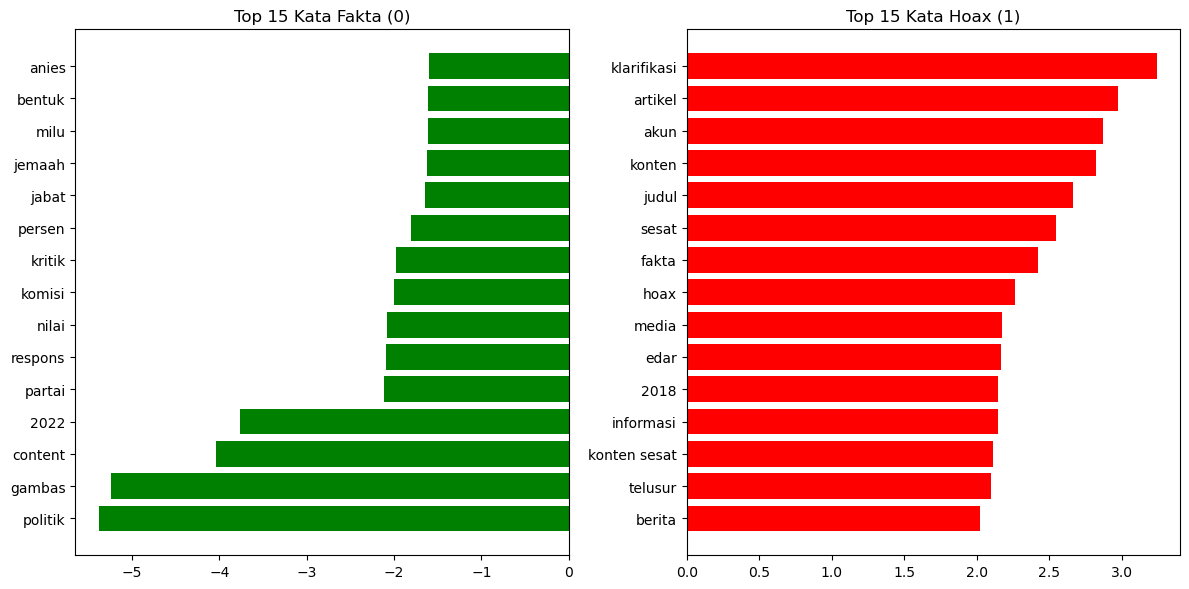

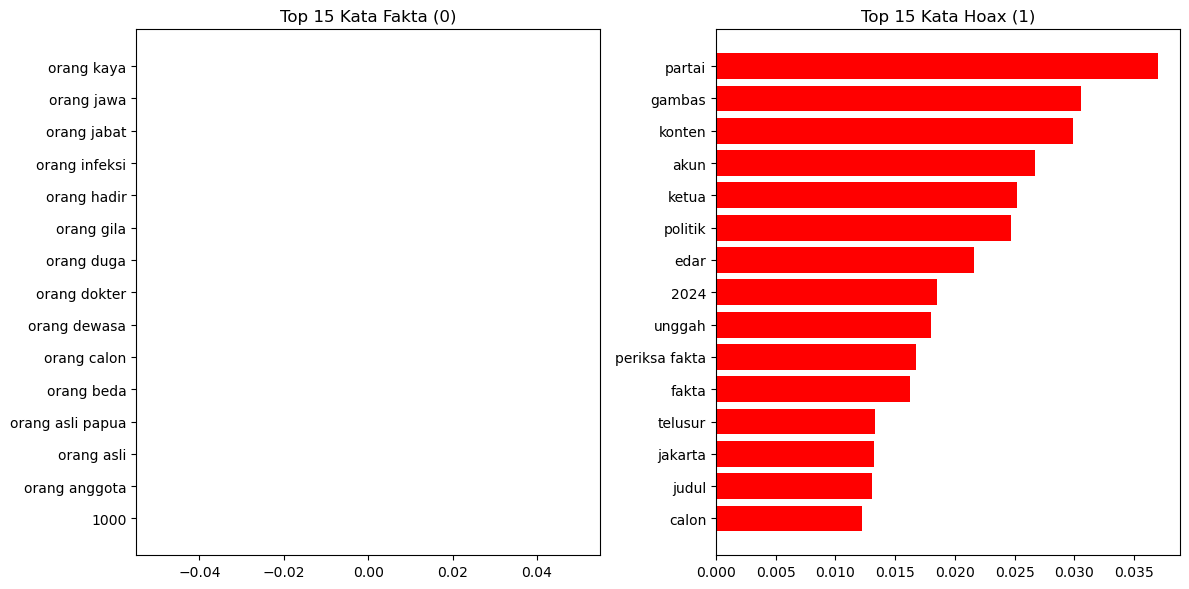

In [17]:
show_top_words(nb, top_n=15)
show_top_words(lr, top_n=15)
show_top_words(svm, top_n=15)
show_top_words(rf, top_n=15)